This notebook is intended to look into the CO2 readings from the Mauna Loa Observatory, provided by the [Scripps CO2 Program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html).

**SOURCE:** 

C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000.  I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Acquisition

This data was acquired from the [Scripps CO2 Program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/mlo.html).  For now, this report and supporting workbooks will use a csv and that file will be provided on Github.  

Originally I was going to use the **Daily** dataset in order to use more resampling methods and preparation, but per the metadata, it recommmends use of **weekly** or **monthly** datasets for long term variability.

Future acquisition options: **time permitting**
- **Downloading directly** is complicated by the metadata format of the CSV.  The creator appropriately marks metadata with a % sign so that it can be removed during a read function.  However, the header column also has that % sign. So my options are:
  1. Hard code the **header** start line
    - Any changes in the metadata line count will result in errors (at a minimum I will no longer get column names)
  2. Use the **comment** parameter, then manually provide column names
    - This is fine until they change the columns - which I would consider less likely than changing the metadata
  3. Make a fancy function
    - Do an initial read of the file to count the number of lines with % signs
      - May not work as they use different column widths...so either need index pulled in or a way to just pull the first column
    - Use that final comment row # to pass into a new read_sql as the header line
    
**Direct Link to csv:** https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv


##### Using Data downloaded on 28JUN2022


In [2]:
#glancing at the CSV, the data starts on line 45 (only metadata above)
# -1 for zero index, -1 since column names manually based
df = pd.read_csv("weekly_in_situ_co2_mlo_28JUN2022.csv",header=43,names=['date','co2'])

In [3]:
df.info() #23557 - grabs headers

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3277 non-null   object 
 1   co2     3277 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.3+ KB


In [4]:
#first row should be 3/39/59
df.head()

,date,co2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [5]:
df.tail()

,date,co2
3272,2022-04-30,419.81
3273,2022-05-07,419.64
3274,2022-05-14,421.36
3275,2022-05-21,420.55
3276,2022-05-28,421.34


## Preparation

<AxesSubplot:>

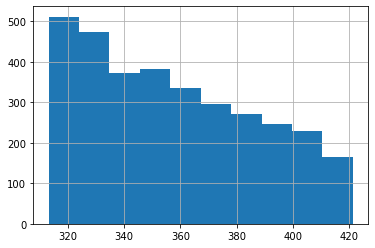

In [6]:
df.co2.hist()

In [7]:
df.co2.isna().mean()

0.0

In [8]:
df.head(20)

,date,co2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48
5,1958-05-03,316.95
6,1958-05-17,317.56
7,1958-05-24,317.99
8,1958-07-05,315.85
9,1958-07-12,315.85


**Notes:** Some missing weeks.  Convert to datetime and look at differences

In [9]:
df['date'] = pd.to_datetime(df.date,format="%Y-%m-%d")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3277 entries, 0 to 3276
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3277 non-null   datetime64[ns]
 1   co2     3277 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.3 KB


In [11]:
deltas = df.date.diff()
deltas

0         NaT
1      7 days
2      7 days
3      7 days
4      7 days
        ...  
3272   7 days
3273   7 days
3274   7 days
3275   7 days
3276   7 days
Name: date, Length: 3277, dtype: timedelta64[ns]

In [12]:
deltas.value_counts()

7 days      3247
14 days       17
21 days        5
28 days        2
35 days        2
42 days        1
63 days        1
133 days       1
Name: date, dtype: int64

In [13]:
#quite a few gaps, some of which are large
#Look at where those are
big_delta = deltas[deltas > "7 days"]
big_delta

6       14 days
8       42 days
15      14 days
17      63 days
30      14 days
34      14 days
44      14 days
54      14 days
211     28 days
226     14 days
232     14 days
242     14 days
270     14 days
278    133 days
280     21 days
286     14 days
386     28 days
399     14 days
409     21 days
899     14 days
1303    35 days
1369    14 days
2300    14 days
2316    21 days
2386    35 days
2432    21 days
2480    14 days
2776    21 days
3154    14 days
Name: date, dtype: timedelta64[ns]

In [14]:
#get approximate dates
df.iloc[big_delta.index]

,date,co2
6,1958-05-17,317.56
8,1958-07-05,315.85
15,1958-08-30,314.14
17,1958-11-08,313.05
30,1959-02-14,316.94
34,1959-03-21,316.73
44,1959-06-06,318.53
54,1959-08-22,315.00
211,1962-09-15,316.65
226,1963-01-05,318.54


**NOTES** There were a decent number of gaps up until 1967 and a few afterwards.  After consideration, instead of doing my own resampling and filling, I will use the already created product (produced by atmospheric PHDs at the Scripps program).

**SWITCHING TO MONTHLY DATA**

In [15]:
dfm = pd.read_csv("monthly_in_situ_co2_mlo_28JUN2022.csv",header=54)

In [16]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0     Yr          782 non-null    object
 1    Mn           782 non-null    object
 2       Date      782 non-null    object
 3         Date    782 non-null    object
 4        CO2      782 non-null    object
 5   seasonally    782 non-null    object
 6           fit   782 non-null    object
 7     seasonally  782 non-null    object
 8         CO2     782 non-null    object
 9    seasonally   782 non-null    object
dtypes: object(10)
memory usage: 61.2+ KB


In [17]:
dfm.head(20)

,Yr,Mn,Date,Date,CO2,seasonally,fit,seasonally,CO2,seasonally
0,,,,,,adjusted,,adjusted fit,filled,adjusted filled
1,,,Excel,,[ppm],[ppm],[ppm],[ppm],[ppm],[ppm]
2,1958,01,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
3,1958,02,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
4,1958,03,21259,1958.2027,315.71,314.44,316.20,314.91,315.71,314.44
5,1958,04,21290,1958.2877,317.45,315.16,317.30,314.99,317.45,315.16
6,1958,05,21320,1958.3699,317.51,314.70,317.87,315.07,317.51,314.70
7,1958,06,21351,1958.4548,-99.99,-99.99,317.26,315.15,317.26,315.15
8,1958,07,21381,1958.5370,315.87,315.20,315.86,315.22,315.87,315.20
9,1958,08,21412,1958.6219,314.93,316.21,313.98,315.29,314.93,316.21


**Notes:** There are a number of options to choose from.  They filled missing data based off a 4-harmonic fit w/ linear gain and used that to get a smoothed dataset with no missing values.  I'd rather use values between the nearest observed values.  For that reason, I will be using Column 5, the monthly readings.

In [18]:
#since the dataframe is a mess, it's easier just to modify the import
#drop header down 2, supply column names, only pull 2 date columns and desired co2
dfm = pd.read_csv("monthly_in_situ_co2_mlo_28JUN2022.csv",header=56,names=['yr','mn','co2'],usecols=[0,1,4])

In [19]:
dfm.head()

,yr,mn,co2
0,1958,1,-99.99
1,1958,2,-99.99
2,1958,3,315.71
3,1958,4,317.45
4,1958,5,317.51


In [20]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      780 non-null    int64  
 1   mn      780 non-null    int64  
 2   co2     780 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 18.4 KB


In [21]:
#Convert to strings and pad if necessary
dfm.yr = dfm.yr.astype(str)
dfm.mn = dfm.mn.astype(str).str.zfill(2)
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      780 non-null    object 
 1   mn      780 non-null    object 
 2   co2     780 non-null    float64
dtypes: float64(1), object(2)
memory usage: 18.4+ KB


In [22]:
#Get a date, set as middle of month
dfm['date'] = dfm.yr + '-' + dfm.mn + '-15'
dfm.head(13)

,yr,mn,co2,date
0,1958,01,-99.99,1958-01-15
1,1958,02,-99.99,1958-02-15
2,1958,03,315.71,1958-03-15
3,1958,04,317.45,1958-04-15
4,1958,05,317.51,1958-05-15
5,1958,06,-99.99,1958-06-15
6,1958,07,315.87,1958-07-15
7,1958,08,314.93,1958-08-15
8,1958,09,313.21,1958-09-15
9,1958,10,-99.99,1958-10-15


In [23]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      780 non-null    object 
 1   mn      780 non-null    object 
 2   co2     780 non-null    float64
 3   date    780 non-null    object 
dtypes: float64(1), object(3)
memory usage: 24.5+ KB


In [24]:
dfm['date'] = pd.to_datetime(dfm.date,format="%Y-%m-%d")
dfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   yr      780 non-null    object        
 1   mn      780 non-null    object        
 2   co2     780 non-null    float64       
 3   date    780 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 24.5+ KB


In [25]:
#check gaps
dfm.date.diff().value_counts()

31 days    454
30 days    260
28 days     49
29 days     16
Name: date, dtype: int64

**Notes:** No month gaps

In [26]:
#set as index
dfm = dfm.set_index('date').sort_index()
dfm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 1958-01-15 to 2022-12-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      780 non-null    object 
 1   mn      780 non-null    object 
 2   co2     780 non-null    float64
dtypes: float64(1), object(2)
memory usage: 24.4+ KB


<AxesSubplot:>

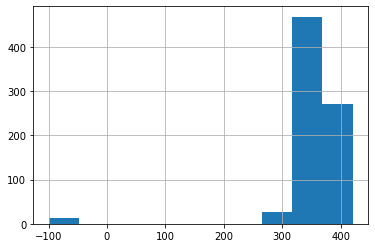

In [27]:
#check values
dfm.co2.hist()

**Notes:** Per metadata, -99 indicates null values

In [29]:
dfm[dfm.co2==-99.99]

,yr,mn,co2
date,,,
1958-01-15,1958,01,-99.99
1958-02-15,1958,02,-99.99
1958-06-15,1958,06,-99.99
1958-10-15,1958,10,-99.99
1964-02-15,1964,02,-99.99
1964-03-15,1964,03,-99.99
1964-04-15,1964,04,-99.99
2022-06-15,2022,06,-99.99
2022-07-15,2022,07,-99.99


**NOTES:** Looking at where the missing values are, we can definitely drop the last few rows (for dates that haven't happened yet).  Normally I would want to keep the 1958-1964 data, and I would impute the values by taking the average of the prior and next value.  However, multiple of those have multi-month gaps, so I am instead choosing to just drop those 6 years. 

In [31]:
dfm = dfm['1964-05':'2022-05']

<AxesSubplot:>

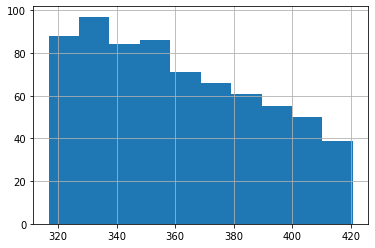

In [32]:
dfm.co2.hist()

### Preparation Action Summary:
- Pull in only a subset of the csv
- convert yr and month to strings
- pad month to assist in datetime conversion
- Convert date column to datetime
- Set as index and sort
- Remove nulls by shortening time series

##### Drop steps into a function

In [33]:
def get_CO2_data():
    '''
    This function acquires and preps Mauna Loa CO2. Data must first exist in a csv in the working directory.
    Returns a dataframe with a datetime index and a single CO2 column.
    Assumes using file downloaded on 28JUN2022 that contains data through the end of May
    
    Returns: Pandas Dataframe
    '''
    #read csv
    dfm = pd.read_csv("monthly_in_situ_co2_mlo_28JUN2022.csv",header=56,names=['yr','mn','co2'],usecols=[0,1,4])
    #Convert to strings and pad if necessary
    dfm.yr = dfm.yr.astype(str)
    dfm.mn = dfm.mn.astype(str).str.zfill(2)
    #create date column
    dfm['date'] = dfm.yr + '-' + dfm.mn + '-15'
    #convert date column to datetime format
    dfm['date'] = pd.to_datetime(dfm.date,format="%Y-%m-%d")
    #set date column as index and sort
    dfm = dfm.set_index('date').sort_index()
    #drop the null months which are on the edges
    dfm = dfm['1964-05':'2022-05']
    return dfm

In [34]:
#test function
df2 = get_CO2_data()
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 697 entries, 1964-05-15 to 2022-05-15
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      697 non-null    object 
 1   mn      697 non-null    object 
 2   co2     697 non-null    float64
dtypes: float64(1), object(2)
memory usage: 21.8+ KB


<AxesSubplot:xlabel='date'>

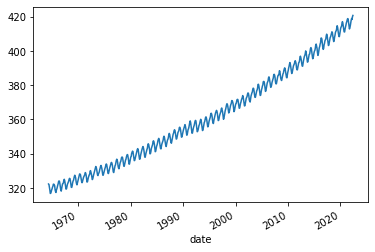

In [35]:
df2.co2.plot()

# OTHER NOTES

SPLIT CHOICES:
- Use only most recent 20 or 30 years for analysis
  - do 5 year splits for validate and train

##### Using Data downloaded day of  **TIME PERMITTING** - FUTURE CONSIDERATIONS

Things to consider:
- Does/can the metadata change
  - May Change Header start line
  - Header line may still start with "% Yr" however metadata itself has that in it
    - So maybe use col 1 == "% Yr" and col 2 == "Mn"
    - % seems to indicate non data rows.  So maybe I can somehow use that to find last % line, which is header line
- Time split
  - Would need to not hard code any dates
    - All relative
  - Would need an appropriate split
    - T - X years
  - If seasonality chooses full years, would need to handle that as well
- Date
  - Would want to pull date (of download), but could just use last reading date


